[(0.0, 0.0, 0.0), (2.8440681844173143, -0.15866637505811543, -1.0299747344339316), (3.3082271713603753, -0.38763848518756694, 0.4727578979469236), (5.085686502043831, 1.0135112774134623, 2.6298671989564664), (10.0, 5.0, 5.0)]


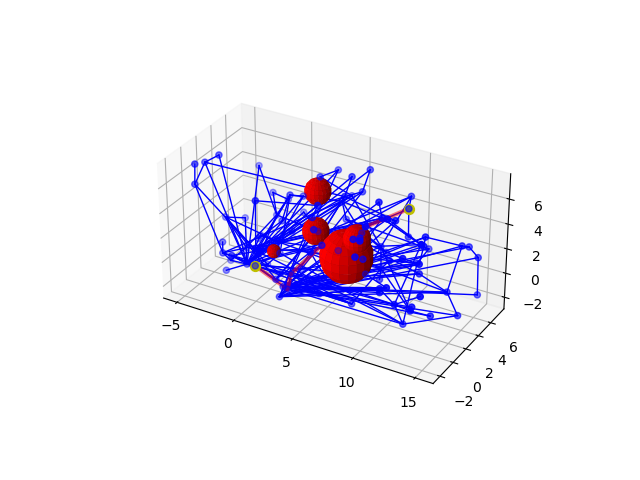

A path was found: True


'\n# some plotting and debugging, still work in progress\n\nfig = plt.figure()\nax = plt.axes(projection =\'3d\')\nu, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]\nobstacles = [(1.,1.,1.,2.),(3.,4.,5.,1.),(4,2,3,1)]\nlines = [(0.,0.,0.),(1.,1.,1.),(5.,5.,5.),(3.,3.,3.)]\n\n# defining coordinates for the 2 points.\nx = np.array([1, 5])\ny = np.array([2, 3])\nz = np.array([-5, 0])\nl = Line((x[0],y[0],z[0]),(x[1],y[1],z[1]))\nprint(trough_obstacle(obstacles,l))\nprint(in_obstacle(obstacles,(3.5,4.5,5.5)))\n\n# plotting\nax.plot3D(x, y, z)\nfor obstacle in range(len(obstacles)):\n    x = obstacles[obstacle][0]+obstacles[obstacle][3]*np.cos(u)*np.sin(v)\n    y = obstacles[obstacle][1]+obstacles[obstacle][3]*np.sin(u)*np.sin(v)\n    z = obstacles[obstacle][2]+obstacles[obstacle][3]*np.cos(v)\n    ax.plot_surface(x, y, z, color="r")\n\n\nplt.show()\n'

In [79]:
"""
Created on Mon Nov 28 21:26:12 2022

@author: Gebra
"""
# imports
%matplotlib widget

import math
from random import random, randrange, uniform

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from collections import deque
# line class with some metrics to ease graph creation
class Line():
    # initialize some metrics
    def __init__(self, p0, p1):
        self.p0 = np.array(p0)
        self.p1 = np.array(p1)
        self.direction = np.array(p1) - np.array(p0)
        self.distance = np.linalg.norm(self.direction)
        self.direction = self.direction/self.distance # normalize

    def path(self, t):
        return self.p0 + t * self.dirn

# graph class
class Graph:
    # initialize some metrix
    def __init__(self, startposition, endposition):
        self.startposition = startposition
        self.endposition = endposition
        self.found_path = False
        # size of searchbox
        self.searchboxsize_x = (startposition[0] - endposition[0])
        self.searchboxsize_y = (startposition[1] - endposition[1])
        self.searchboxsize_z = (startposition[2] - endposition[2])
        # location of seachbox startpoint: two times size of box between start and end position
        self.searchbegin_x = self.startposition[0] + (self.searchboxsize_x/2) 
        self.searchbegin_y = self.startposition[1] + (self.searchboxsize_y/2) 
        self.searchbegin_z = self.startposition[2] + (self.searchboxsize_z/2) 
        
        self.vertices = [startposition]
        self.edges = [] # contains the indices of the vertices
        self.indices = {startposition:0} # dictonary with indices for the vertices
        self.distances = {0:0.} # dictonary with distances for each index
        self.connections = {0:[]} # dictonary with connecting node(s)
        
    # creating a random position within search frame
    def randpos(self, obstacles = None, rand_radius = None, bias = None, obstacle_bias = False):
        if obstacle_bias == False:
            # create random values between 0 and 1
            x = random()
            y = random()
            z = random()
            # convert to value within searchbox
            posx = self.searchbegin_x - x*self.searchboxsize_x*2
            posy = self.searchbegin_y - y*self.searchboxsize_y*2
            posz = self.searchbegin_z - z*self.searchboxsize_z*2
            
        else:
            select = random()
            if select < bias:
                # create random values between 0 and 1
                x = random()
                y = random()
                z = random()
                # convert to value within searchbox
                posx = self.searchbegin_x - x*self.searchboxsize_x*2
                posy = self.searchbegin_y - y*self.searchboxsize_y*2
                posz = self.searchbegin_z - z*self.searchboxsize_z*2
            else:
                rand_obs = randrange(0,len(obstacles))
                total_radius = obstacles[rand_obs][3] + rand_radius
                posx = obstacles[rand_obs][0]+ uniform(-total_radius,total_radius)
                posy = obstacles[rand_obs][1]+ uniform(-total_radius,total_radius)
                posz = obstacles[rand_obs][2]+ uniform(-total_radius,total_radius)
                
        return posx, posy, posz
    def add_vertex(self, vertex):
        try: # check if vertex already exists
            idx = self.indices[vertex]
        except:# otherwise add to list and dictionaries
            idx = len(self.vertices)
            self.vertices.append(vertex)
            self.indices[vertex] = idx
            self.connections[idx] = []
        return idx

    def add_edge(self, idx1, idx2, cost):
        self.edges.append((idx1, idx2)) # add edge based on indices
        self.connections[idx1].append((idx2, cost)) #add the connecting nodes and costs
        self.connections[idx2].append((idx1, cost))

# RRT algorithm
def RRT(startposition, endposition, obstacles, iterations, threshold, rand_radius, bias, obstacle_bias):
    RRT_Graph = Graph(startposition, endposition)
    
    for i in range(iterations):
        randpos = RRT_Graph.randpos(obstacles, rand_radius, bias, obstacle_bias)
        
        if in_obstacle(obstacles, randpos):
            continue
            
        near_vex, near_idx = nearest_node(RRT_Graph, randpos, obstacles)
        if near_vex is None:
            continue
        
        new_idx = RRT_Graph.add_vertex(randpos)
        dist = distance(near_vex,randpos)
        RRT_Graph.add_edge(new_idx,near_idx,dist)
        
        end_distance = distance(randpos,RRT_Graph.endposition)
        if end_distance < threshold:
            end_index = RRT_Graph.add_vertex(RRT_Graph.endposition)
            RRT_Graph.add_edge(new_idx,end_index,end_distance)
            RRT_Graph.found_path = True
    return RRT_Graph

# RRT* algorithm
def RRT_s(startposition, endposition, obstacles, iterations, threshold, rand_radius, bias, obstacle_bias):
    RRT_Graph = Graph(startposition, endposition)
    
    for i in range(iterations):
        randpos = RRT_Graph.randpos(obstacles, rand_radius, bias, obstacle_bias)
        
        if in_obstacle(obstacles, randpos):
            continue
            
        near_vex, near_idx = nearest_node(RRT_Graph, randpos, obstacles)
        if near_vex is None:
            continue
        
        new_idx = RRT_Graph.add_vertex(randpos)
        dist = distance(near_vex,randpos)
        RRT_Graph.add_edge(new_idx,near_idx,dist)
        RRT_Graph.distances[new_idx] = RRT_Graph.distances[near_idx] + dist #update the distances
        
        # update nearby vertices distance (if shorter)
        for vertex in RRT_Graph.vertices:
            if vertex == randpos:
                continue

            dist = distance(vertex, randpos)
            #if dist > 2:
             #   continue
                
            line = Line(vertex, randpos)
            if trough_obstacle(obstacles, line):
                continue

            idx = RRT_Graph.indices[vertex]
            if (RRT_Graph.distances[new_idx] + dist) < (RRT_Graph.distances[idx]):
                RRT_Graph.add_edge(idx, new_idx, dist)
                RRT_Graph.distances[idx] = RRT_Graph.distances[new_idx] + dist

        
        end_distance = distance(randpos,RRT_Graph.endposition)
        if end_distance < threshold:
            end_index = RRT_Graph.add_vertex(RRT_Graph.endposition)
            RRT_Graph.add_edge(new_idx,end_index,end_distance)
            try:
                RRT_Graph.distances[end_index] = min(RRT_Graph.distances[end_index], RRT_Graph.distances[new_idx]+end_distance)
            except:
                RRT_Graph.distances[end_index] = RRT_Graph.distances[new_idx]+end_distance

            RRT_Graph.found_path = True
    return RRT_Graph


# Plotting function
def plot_graph(Graph, obstacles, startposition, endposition, found_path=None):
    fig = plt.figure()
    ax = plt.axes(projection ='3d')
    size_x = endposition[0] - startposition[0]
    size_y = endposition[1] - startposition[1]
    size_z = endposition[2] - startposition[2]
    
    vex_x = [x for x, y, z in Graph.vertices]
    vex_y = [y for x, y, z in Graph.vertices]
    vex_z = [z for x, y, z in Graph.vertices]
    
    for obstacle in range(len(obstacles)):
        x = obstacles[obstacle][0]+obstacles[obstacle][3]*np.cos(u)*np.sin(v)
        y = obstacles[obstacle][1]+obstacles[obstacle][3]*np.sin(u)*np.sin(v)
        z = obstacles[obstacle][2]+obstacles[obstacle][3]*np.cos(v)
        ax.plot_surface(x, y, z, color="r")
    
    ax.scatter(vex_x,vex_y,vex_z, color="b")
    ax.scatter(Graph.startposition[0],Graph.startposition[1],Graph.startposition[2],s=50, color="y")
    ax.scatter(Graph.endposition[0],Graph.endposition[1],Graph.endposition[2],s=50, color="y")
    
    for edge in Graph.edges:
        x = np.array([Graph.vertices[edge[0]][0],Graph.vertices[edge[1]][0]])
        y = np.array([Graph.vertices[edge[0]][1],Graph.vertices[edge[1]][1]])
        z = np.array([Graph.vertices[edge[0]][2],Graph.vertices[edge[1]][2]])
        ax.plot3D(x, y, z, color="b",linewidth=1)
    
    if found_path is not None:
        for path in range(len(found_path)-1):
            x = np.array([found_path[path][0],found_path[path+1][0]])
            y = np.array([found_path[path][1],found_path[path+1][1]])
            z = np.array([found_path[path][2],found_path[path+1][2]])
            
            ax.plot3D(x, y, z, color="r",linewidth=3, alpha=0.5)
    ax.set_box_aspect(aspect = (size_x/size_z,size_y/size_z,1))
    plt.show()
    print('A path was found:', Graph.found_path)

# calculate intersection between line and obstacle
# still needs some work, only works for spheres
def intersection(obstacle, line):
    r = obstacle[3]
    C = obstacle[:3]
    P = line.p0
    U = line.direction
    Q=P-C
    a = np.dot(U,U)
    b= 2*np.dot(U,Q)
    c = np.dot(Q,Q)-r*r
    d = np.dot(b,b)-4*np.dot(a,c)
    if (line.p0[0] > (obstacle[0]+r) and line.p1[0] > (obstacle[0]+r)) or (line.p0[0] < (obstacle[0]-r) and line.p1[0] < (obstacle[0]-r)) or (line.p0[1] > (obstacle[1]+r) and line.p1[1] > (obstacle[1]+r)) or (line.p0[1] < (obstacle[1]-r) and line.p1[1] < (obstacle[1]-r)) or (line.p0[2] > (obstacle[2]+r) and line.p1[2] > (obstacle[2]+r)) or (line.p0[2] < (obstacle[2]-r) and line.p1[2] < (obstacle[2]-r)):
        return False
    if d < 0:
        return False
    return True

# determine distance between 2 points
def distance(x, y):
    return np.linalg.norm(np.array(x) - np.array(y))

# determine whether a vertex (point) is in one of the obstacles
def in_obstacle(obstacles, vertex):
    for obstacle in obstacles:
        if distance(obstacle[:3],vertex) < obstacle[3]:
            return True
    return False

# determine whether a edge (line) goes through one of the obstacles
def trough_obstacle(obstacles,line):
    for obstacle in obstacles:
        if intersection(obstacle, line):
            return True
    return False

#find the nearest node
def nearest_node(Graph, vertex, obstacles):
    near_vex = None
    near_idx = None
    min_distance = 10.e10
    for idx, graph_vertex in enumerate(Graph.vertices):
        line = Line(graph_vertex, vertex)
        if trough_obstacle(obstacles,line):
            continue
        
        dist = distance(graph_vertex, vertex)
        if dist < min_distance:
            min_distance = dist
            near_idx = idx
            near_vex = graph_vertex
    return near_vex, near_idx

def dijkstra(Graph):
    
    # Dijkstra algorithm for finding shortest path from start position to end, from MIT License Copyright (c) 2019 Fanjin Zeng
    
    srcIdx = Graph.indices[Graph.startposition]
    dstIdx = Graph.indices[Graph.endposition]

    # build dijkstra
    nodes = list(Graph.connections.keys())
    dist = {node: float('inf') for node in nodes}
    prev = {node: None for node in nodes}
    dist[srcIdx] = 0

    while nodes:
        curNode = min(nodes, key=lambda node: dist[node])
        nodes.remove(curNode)
        if dist[curNode] == float('inf'):
            break

        for neighbor, cost in Graph.connections[curNode]:
            newCost = dist[curNode] + cost
            if newCost < dist[neighbor]:
                dist[neighbor] = newCost
                prev[neighbor] = curNode

    # retrieve path
    path = deque()
    curNode = dstIdx
    while prev[curNode] is not None:
        path.appendleft(Graph.vertices[curNode])
        curNode = prev[curNode]
    path.appendleft(Graph.vertices[curNode])
    return list(path)

if __name__ == '__main__':
    startposition = (0.,0.,0.)
    endposition = (10.,5.,5.)
    obstacles = [(1.,1.,1.,.5),(3.,4.,5.,1.),(4,2,3,1),(6,3,1,2),(8,1,4,1)]
    iterations = 100
    threshold = 2 #for marking the end position as found
    
    #some parameters for the obstacle bias attempt
    bias = 0.5
    obstacle_bias = False
    rand_radius = 1.
    
    #Graph = RRT(startposition, endposition, obstacles, iterations, threshold, rand_radius, bias, obstacle_bias)
    Graph = RRT_s(startposition, endposition, obstacles, iterations, threshold, rand_radius, bias, obstacle_bias)
    
    if Graph.found_path:
        path = dijkstra(Graph)
        print(path)
        plot_graph(Graph, obstacles, startposition, endposition, path)
    else:
        plot_graph(Graph, obstacles, startposition, endposition)

